<a href="https://colab.research.google.com/github/MatthewK84/MattConformalPrediction/blob/main/Conformal_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this example, we’ll use the hourly dataset from the M4 Competition. We first need to download the data from a URL and then load it as a pandas dataframe. Notice that we’ll load the train and the test data separately. We’ll also rename the y column of the test data as y_test.

In [1]:
pip install statsforecast -U

In [15]:
import pandas as pd
from tqdm.autonotebook import tqdm
import plotly

train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In [3]:
train.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


Since the goal of this notebook is to generate prediction intervals, we’ll only use the first 8 series of the dataset to reduce the total computational time.

In [4]:
n_series = 8
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

We can plot these series using the statsforecast.plot method from the StatsForecast class. This method has multiple parameters, and the required ones to generate the plots in this notebook are explained below.

df: A pandas dataframe with columns [unique_id, ds, y].
forecasts_df: A pandas dataframe with columns [unique_id, ds] and models.
plot_random: bool = True. Plots the time series randomly.
models: List[str]. A list with the models we want to plot.
level: List[float]. A list with the prediction intervals we want to plot.
engine: str = matplotlib. It can also be matplotlib. plotly generates interactive plots, while matplotlib generates static plots.

In [17]:
from statsforecast import StatsForecast

show = StatsForecast.plot(train, test, plot_random = False, engine = 'plotly')
show

StatsForecast can train multiple models on different time series efficiently. Most of these models can generate a probabilistic forecast, which means that they can produce both point forecasts and prediction intervals.

For this example, we’ll use SimpleExponentialSmoothing and ADIDA which do not provide a prediction interval natively. Thus, it makes sense to use Conformal Prediction to generate the prediction interval.

We’ll also show using it with ARIMA to provide prediction intervals that don’t assume normality.

To use these models, we first need to import them from statsforecast.models and then we need to instantiate them.

In [6]:
from statsforecast.models import SeasonalExponentialSmoothing, ADIDA, ARIMA
from statsforecast.utils import ConformalIntervals

# Create a list of models and instantiation parameters
intervals = ConformalIntervals(h=24, n_windows=2)

models = [
    SeasonalExponentialSmoothing(season_length=24,alpha=0.1, prediction_intervals=intervals),
    ADIDA(prediction_intervals=intervals),
    ARIMA(order=(24,0,12), season_length=24, prediction_intervals=intervals),
]

To instantiate a new StatsForecast object, we need the following parameters:

df: The dataframe with the training data.
models: The list of models defined in the previous step.
freq: A string indicating the frequency of the data. See pandas’ available frequencies.
n_jobs: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores.

In [7]:
sf = StatsForecast(
    df=train,
    models=models,
    freq='H',
)

Now we’re ready to generate the forecasts and the prediction intervals. To do this, we’ll use the forecast method, which takes two arguments:

h: An integer that represent the forecasting horizon. In this case, we’ll forecast the next 24 hours.
level: A list of floats with the confidence levels of the prediction intervals. For example, level=[95] means that the range of values should include the actual future value with probability 95%.

In [8]:
levels = [80, 90] # confidence levels of the prediction intervals

forecasts = sf.forecast(h=24, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

,unique_id,ds,SeasonalES,SeasonalES-lo-90,SeasonalES-lo-80,SeasonalES-hi-80,SeasonalES-hi-90,ADIDA,ADIDA-lo-90,ADIDA-lo-80,ADIDA-hi-80,ADIDA-hi-90,ARIMA,ARIMA-lo-90,ARIMA-lo-80,ARIMA-hi-80,ARIMA-hi-90
0,H1,701,624.132690,561.315369,565.365356,682.900024,686.950012,747.292542,668.049988,672.099976,822.485107,826.535095,625.856689,564.763367,568.813416,682.900024,686.950012
1,H1,702,555.698181,501.886902,510.377441,601.018921,609.509460,747.292542,560.200012,570.400024,924.185059,934.385071,564.304626,516.517822,522.426453,606.182739,612.091370
2,H1,703,514.403015,468.656036,471.506042,557.299988,560.150024,747.292542,546.849976,549.700012,944.885071,947.735107,525.676453,491.202881,494.052887,557.299988,560.150024
3,H1,704,482.057892,438.715790,442.315796,521.799988,525.400024,747.292542,508.600006,512.200012,982.385071,985.985107,505.305176,485.118805,488.627258,521.983093,525.491577
4,H1,705,460.222534,419.595062,422.745056,497.700012,500.850006,747.292542,486.149994,489.299988,1005.285095,1008.435059,488.541260,474.570160,476.057770,501.024750,502.512390


Here we’ll plot the different intervals using matplotlib for one timeseries.

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def _plot_fcst(fcst, train, model):
    fig, ax = plt.subplots(1, 1, figsize = (20,7))
    plt.plot(np.arange(0, len(train['y'])), train['y'])
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[model], label=model)
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-lo-90'], color = 'r', label='lo-90')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-hi-90'], color = 'r', label='hi-90')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-lo-80'], color = 'g', label='lo-80')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-hi-80'], color = 'g', label='hi-80')
    plt.legend()

In [10]:
id = "H105"
temp_train = train.loc[train['unique_id'] == id]
temp_forecast = forecasts.loc[forecasts['unique_id'] == id]

The prediction interval with the SeasonalExponentialSmoothing seen below. Even if the model generates a point forecast, we are able to get a prediction interval. The 80% prediction interval does not cross the 90% prediction interval, which is a sign that the intervals are calibrated.

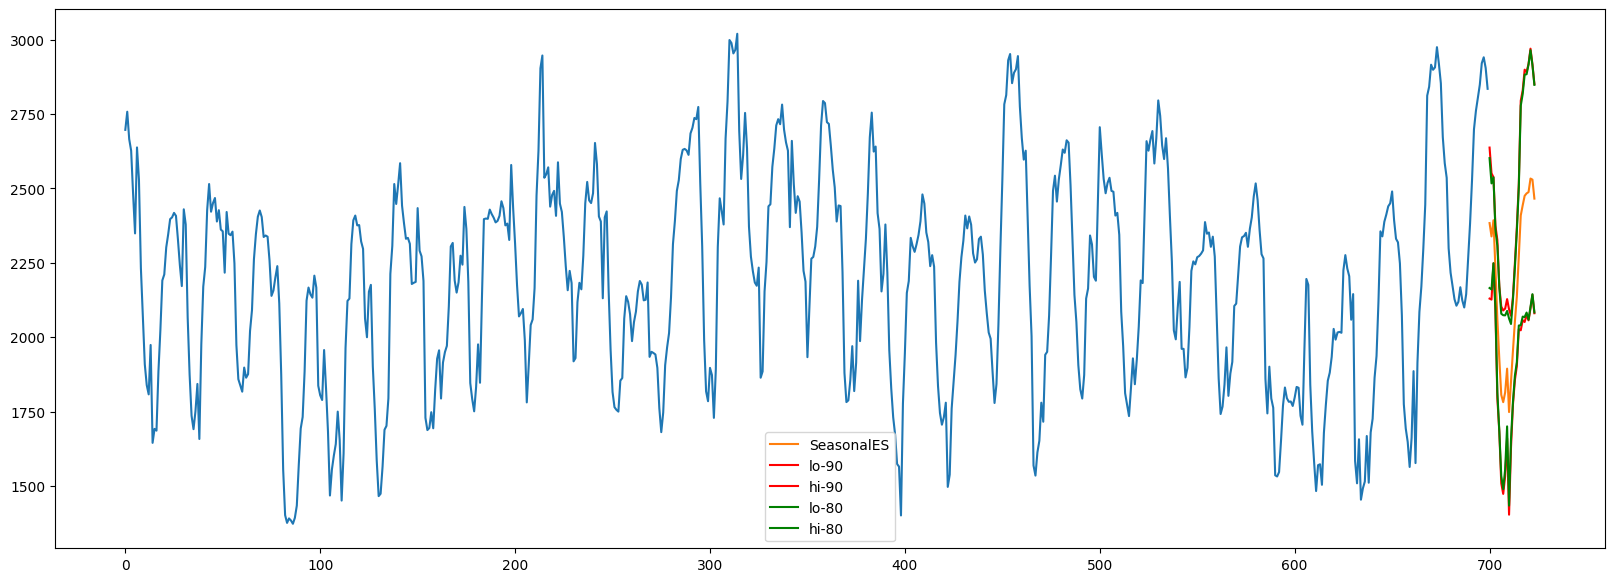

In [11]:
_plot_fcst(temp_forecast, temp_train, "SeasonalES")

For weaker fitting models, the conformal prediction interval can be larger. A better model corresponds to a narrower interval.

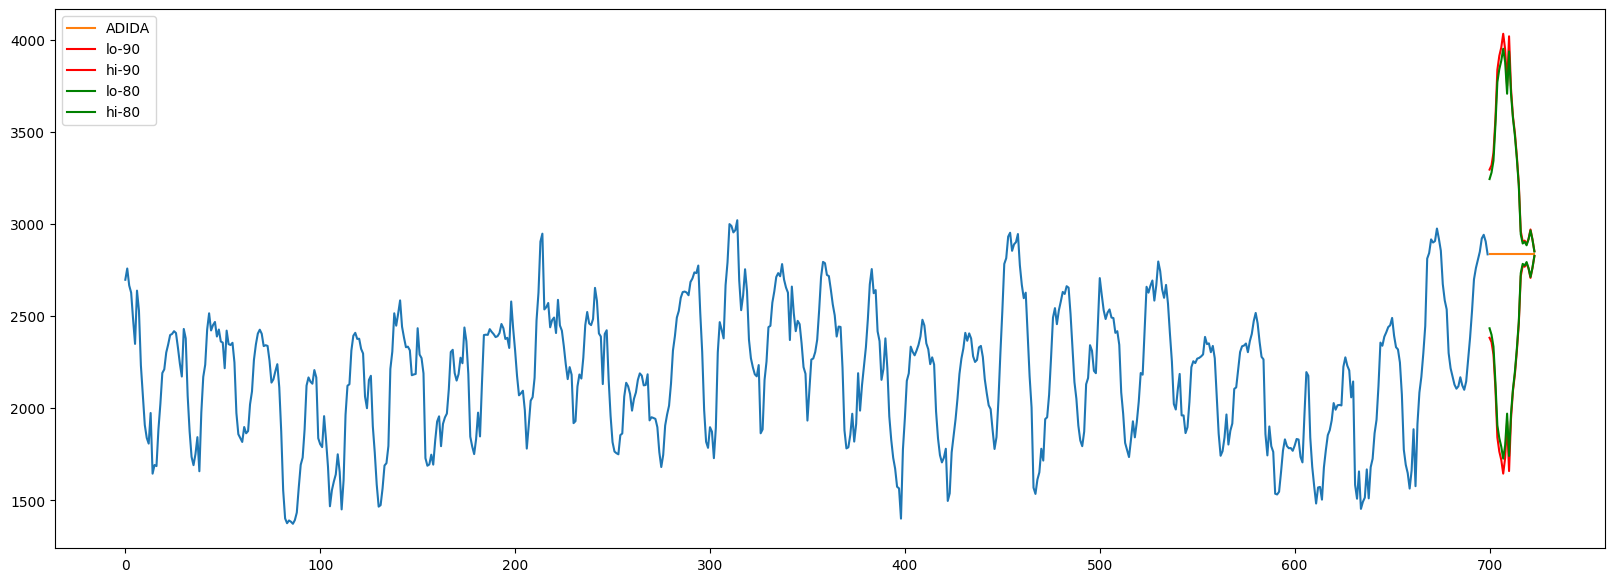

In [12]:
_plot_fcst(temp_forecast, temp_train,"ADIDA")

ARIMA is an example of a model that provides a forecast distribution, but we can still use conformal prediction to generate the prediction interval. As mentioned earlier, this method has the benefit of not assuming normality.

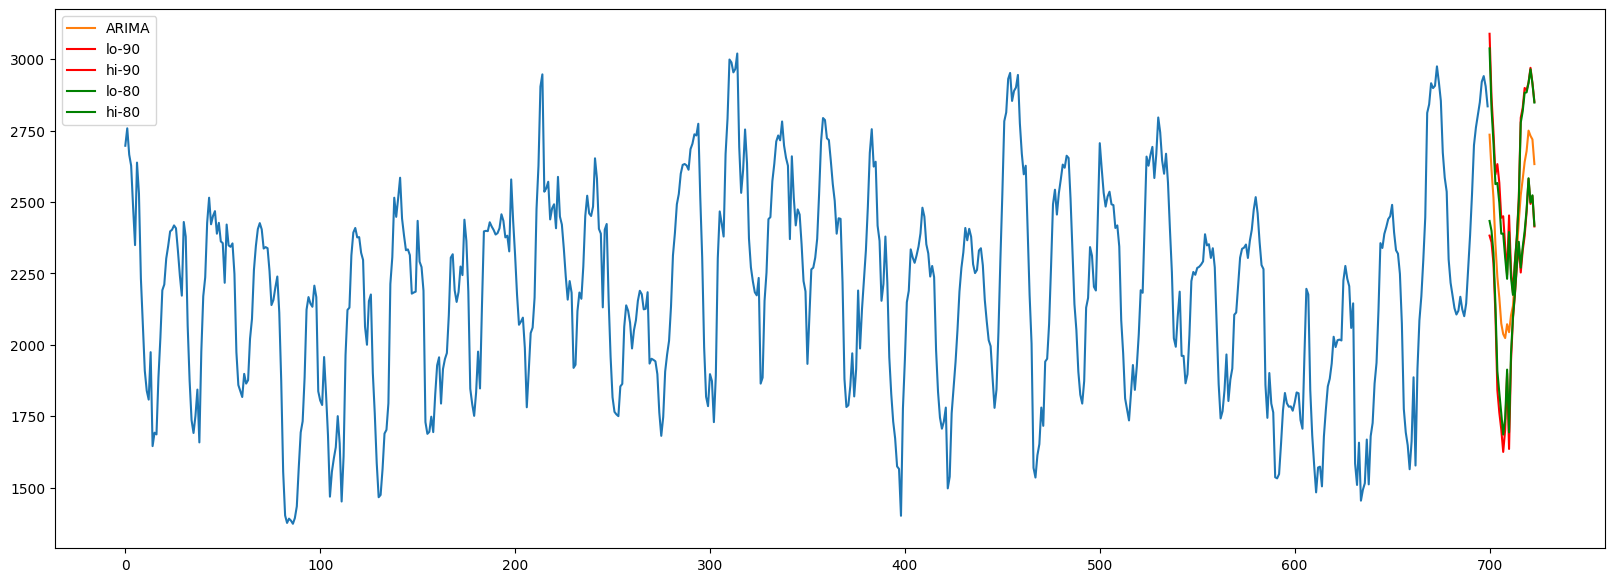

In [13]:
_plot_fcst(temp_forecast, temp_train,"ARIMA")

Alternatively, the prediction interval can be defined on the StatsForecast object. This will apply to all models that don’t have the prediction_intervals defined.

In [14]:
from statsforecast.models import SimpleExponentialSmoothing, ADIDA
from statsforecast.utils import ConformalIntervals
from statsforecast import StatsForecast

models = [
    SimpleExponentialSmoothing(alpha=0.1),
    ADIDA()
]

res = StatsForecast(
    df=train,
    models=models,
    freq='H').forecast(h=24, prediction_intervals=ConformalIntervals(h=24, n_windows=2), level=[80])

res.head().reset_index()

,unique_id,ds,SES,SES-lo-80,SES-hi-80,ADIDA,ADIDA-lo-80,ADIDA-hi-80
0,H1,701,742.669067,672.099976,813.238159,747.292542,672.099976,822.485107
1,H1,702,742.669067,570.400024,914.938110,747.292542,570.400024,924.185059
2,H1,703,742.669067,549.700012,935.638123,747.292542,549.700012,944.885071
3,H1,704,742.669067,512.200012,973.138123,747.292542,512.200012,982.385071
4,H1,705,742.669067,489.299988,996.038147,747.292542,489.299988,1005.285095
